# Pathway Check

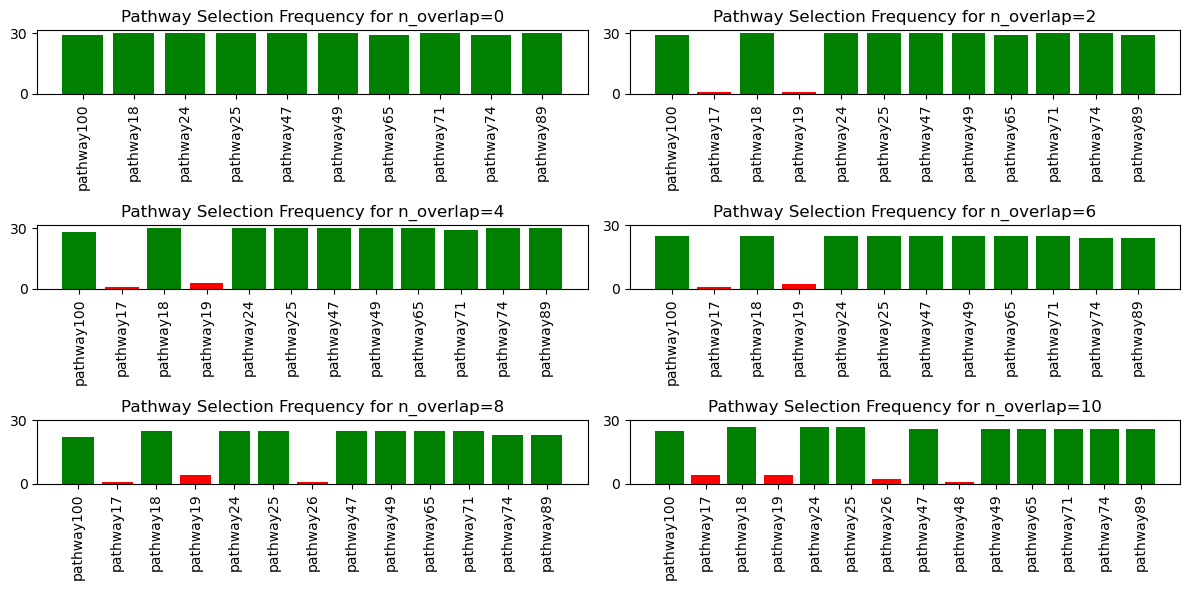

In [3]:
import scanpy as sc
import numpy as np
import pickle as pkl
import sys

sys.path.append('./model')  # 添加model文件夹到路径
sys.path.append('./data')  # 

adata = sc.read_h5ad('./data/simulation/overlap_data/n_overlap_beta4/simu_scRNAseq_100pathways_4overlaplog_seed=46.h5ad')
adata.uns['effect_pathways']

# Loop through the files for n_overlap=0 to n_overlap=11
params_range = range(0, 11,2)


import matplotlib.pyplot as plt
# Get the effect pathways
effect_pathways = set(adata.uns['effect_pathways'])
# Collect data for all i
all_counts = {}
for i in params_range:
    pathway_selection_count = {pathway: 0 for pathway in adata.uns['all_pathways']}
    for seed in np.arange(46, 76):
        file_path = f'./results/simulation_exp/scKP_run/n_overlap={i}/100pathways_{i}overlaplog_seed={seed}_lambda.pkl'
        with open(file_path, 'rb') as f:
            model = pkl.load(f)
        selected_pathways = model.select_pathway(fdr=0.2)
        for pathway in selected_pathways:
            pathway_selection_count[pathway] += 1
    all_counts[i] = pathway_selection_count
    
# Create a big figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 6))
axes = axes.flatten()  # Flatten to 1D array for easy indexing
for idx, i in enumerate(params_range):
    selected_pathways = all_counts[i]
    # Filter pathways with frequency > 0
    filtered_pathways = {k: v for k, v in selected_pathways.items() if v > 0}
    # Colors for filtered pathways: green for effect pathways, red otherwise
    colors_filtered = ['green' if pathway in effect_pathways else 'red' for pathway in filtered_pathways.keys()]
    axes[idx].bar(filtered_pathways.keys(), filtered_pathways.values(), color=colors_filtered)
    axes[idx].set_title(f'Pathway Selection Frequency for n_overlap={i}')
    axes[idx].tick_params(axis='x', rotation=90, labelsize=10)
    axes[idx].set_yticks([0,30])
plt.tight_layout()
plt.savefig('./pathway_selection_frequency_overlap.pdf', dpi=300,bbox_inches='tight')
plt.show()
# output_file = f'./scKP_run/n_overlap={i}/pathway_selection_count.pkl'
# with open(output_file, 'wb') as f:
#     pkl.dump(pathway_selection_count, f)
        

# FDR and Power

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

colors = ['#46788E','#78B7C9', '#F6E093','#E58B7B',  '#97B319']

def load_res(res_type='fdr',param='overlap',params_range=range(0,11,2)):
    values_padog=pd.read_csv(f'./results/simulation_exp/PADOG_{param}_results/PADOG_{param}_{res_type}_values.csv')
    values_camera=pd.read_csv(f'./results/simulation_exp/CAMERA_{param}_results/CAMERA_{param}_{res_type}_values.csv')
    values_gsea=pd.read_csv(f'./results/simulation_exp/GSEA_{param}_results/GSEA_{param}_{res_type}_values.csv')
    values_scpa=pd.read_csv(f'./results/simulation_exp/SCPA_{param}_results/SCPA_{param}_{res_type}_values.csv')
    values_camera.columns = values_padog.columns
    values_gsea.columns = values_padog.columns
    values_scpa.columns = values_padog.columns
    
    # Loop through the files for n_overlap=0 to n_overlap=11
    values_list = []
    for i in params_range:
        file_path = f'./results/simulation_exp/scKP_run3/results/n_samples={i}_results.npz' \
            if param=='sample' \
            else f'./results/simulation_exp/scKP_run2/results/n_sparsity={i}_results.npz' \
            if param=='sparsity' \
            else f'./results/simulation_exp/scKP_run/results/n_overlap={i}_results.npz' \
            if param=='overlap' \
            else f'./results/simulation_exp/scKP_run_fdr/results/fdr={i}_results.npz'
        data = np.load(file_path)
        values_list.append(data['fdrs'] if res_type=='fdr' else data['powers'])
    
    values_scknockpath=pd.DataFrame(values_list,index=values_padog.columns).T
    values_camera['Method'] = 'CAMERA'
    values_gsea['Method'] = 'GSEA'
    values_scpa['Method'] = 'SCPA'  
    values_padog['Method'] = 'PADOG'
    values_scknockpath['Method'] = 'scKnockPath'
    
    combined_values=pd.concat([values_scknockpath,values_gsea, values_scpa,values_padog, values_camera])
    combined_values_melted = combined_values.melt(id_vars=['Method'], var_name=f'n_{param}', value_name='FDR' if res_type=='fdr' else 'Power')

    return combined_values_melted


def plot_fdr_power_boxplots(
    combined_fdr_values_melted,
    combined_powers_values_melted,
    colors,
    x_ticks,
    param='overlap',
    x_fontsize=25,
    y_fontsize=25,
    x_label='Number of Overlapping Genes',
    save_path='./combined_vertical_overlap_boxplot_fdr_power.pdf'
):
    """
    Plots combined boxplots for FDR and Power values with vertical arrangement.

    Parameters:
    - combined_fdr_values_melted: DataFrame containing melted FDR values.
    - combined_powers_values_melted: DataFrame containing melted Power values.
    - colors: List of colors for the boxplots.
    - save_path: Path to save the resulting figure.
    """
    # Create a combined figure with vertical arrangement (FDR on top, Power on bottom)
    plt.style.use('default')  # Reset to clean style
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

    # Set overall figure properties for publication quality
    plt.rcParams.update({
        'font.size': 12,
        'axes.linewidth': 1.2,
        'axes.edgecolor': 'black',
        'axes.facecolor': 'white',
        'figure.facecolor': 'white'
    })

    # Plot 1: FDR Values (Top panel)
    ax1.axhline(y=0.2, color='red', linestyle='--', linewidth=2.5, alpha=0.8, 
                label='FDR threshold = 0.2', zorder=10)
    sns.boxplot(x=param, y='FDR', hue='Method', data=combined_fdr_values_melted, 
                palette=colors, ax=ax1, linewidth=1.2, fliersize=4)

    # Add subtle vertical lines to separate each group for FDR plot
    for i in range(1, 6):
        ax1.axvline(x=i - 0.5, color='lightgray', linestyle='-', linewidth=0.8, alpha=0.6)

    # Customize FDR plot appearance

    ax1.set_xticks(range(6))
    ax1.set_xticklabels(x_ticks)
    ax1.tick_params(axis='y', labelsize=y_fontsize, width=1.2)
    ax1.tick_params(axis='x', labelsize=x_fontsize, width=1.2)
    ax1.set_xlabel('')  # Remove x-label for top plot
    ax1.set_ylabel('False Discovery Rate', fontsize=y_fontsize, labelpad=10,fontweight='bold')
    ax1.set_ylim(-0.05, 1.05)

    # Add grid for better readability
    ax1.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax1.set_axisbelow(True)

    # Add the FDR threshold legend
    ax1.legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, 
            shadow=True, framealpha=0.9)

    # Plot 2: Power Values (Bottom panel)
    sns.boxplot(x=param, y='Power', hue='Method', data=combined_powers_values_melted, 
                palette=colors, ax=ax2, linewidth=1.2, fliersize=4)

    # Add subtle vertical lines to separate each group for Power plot
    for i in range(1, 6):
        ax2.axvline(x=i - 0.5, color='lightgray', linestyle='-', linewidth=0.8, alpha=0.6)

    # Customize Power plot appearance
    ax2.set_xticks(range(6))
    ax2.set_xticklabels(x_ticks)
    ax2.tick_params(axis='y', labelsize=y_fontsize, width=1.2)
    ax2.tick_params(axis='x', labelsize=x_fontsize, width=1.2)
    ax2.set_xlabel(x_label, fontsize=x_fontsize,fontweight='bold')
    ax2.set_ylabel('Statistical Power', fontsize=y_fontsize, labelpad=10,fontweight='bold')
    ax2.set_ylim(-0.05, 1.05)


    # Add grid for better readability
    ax2.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax2.set_axisbelow(True)

    # Create a beautiful shared legend at the bottom
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, 
            loc='lower center', 
            bbox_to_anchor=(0.5, -0.02),
            ncol=5, 
            fontsize=14, 
            frameon=True, 
            fancybox=True, 
            shadow=True,
            borderaxespad=0,
            columnspacing=1.5,
            handletextpad=0.5)

    # Remove individual legends
    ax1.get_legend().remove() if len(ax1.get_legend().get_texts()) > 1 else None
    ax2.legend().set_visible(False)

    # Optimize spacing and layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.35, bottom=0.12, top=0.95, left=0.08, right=0.97)

    # Add a subtle border around the entire figure
    for spine in ['top', 'bottom', 'left', 'right']:
        ax1.spines[spine].set_linewidth(1.2)
        ax2.spines[spine].set_linewidth(1.2)

    # Save the optimized combined figure
    plt.savefig(save_path, 
                dpi=300, 
                bbox_inches='tight', 
                facecolor='white', 
                edgecolor='none',
                pad_inches=0.1)
    plt.show()


def plot_fdr_power_line(
    combined_fdr_values_melted,
    combined_powers_values_melted,
    colors,
    x_ticks,
    param='overlap',
    x_fontsize=25,
    y_fontsize=25,
    x_label='Number of Overlapping Genes',
    save_path='./combined_vertical_overlap_line_fdr_power.pdf'
):
    """
    Plots combined line plots for FDR and Power values with vertical arrangement.

    Parameters:
    - combined_fdr_values_melted: DataFrame containing melted FDR values.
    - combined_powers_values_melted: DataFrame containing melted Power values.
    - colors: List of colors for the line plots.
    - save_path: Path to save the resulting figure.
    """
    # Create a combined figure with vertical arrangement (FDR on top, Power on bottom)
    plt.style.use('default')  # Reset to clean style
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

    # Set overall figure properties for publication quality
    plt.rcParams.update({
        'font.size': 12,
        'axes.linewidth': 1.2,
        'axes.edgecolor': 'black',
        'axes.facecolor': 'white',
        'figure.facecolor': 'white'
    })

    # Plot 1: FDR Values (Top panel)
    mean_fdr = combined_fdr_values_melted.dropna(subset=['FDR']).copy()
    mean_fdr['target_fdr'] = mean_fdr[param].str.replace('X', '', regex=False).astype(float)

    summary_fdr = (
        mean_fdr.groupby(['Method', 'target_fdr'], as_index=False)['FDR']
        .mean()
        .sort_values(['Method', 'target_fdr'])
    )

    method_order = combined_fdr_values_melted['Method'].drop_duplicates().tolist()
    palette = dict(zip(method_order, colors))
    sns.lineplot(
        data=summary_fdr,
        x='target_fdr',
        y='FDR',
        hue='Method',
        hue_order=method_order,
        palette=palette,
        marker='o',
        linewidth=3,
        markersize=12,
        ax=ax1,
        legend=False
    )

    ax1.plot(
        x_ticks,
        x_ticks,
        color='black',
        linestyle='--',
        linewidth=2.5,
        label='y = x'
    )
    
    # 对 FDR plot
    ax1.set_xticks(x_ticks)
    ax1.set_xlim(min(x_ticks) - 0.005, max(x_ticks) + 0.01)
    ax1.set_xticklabels([str(x) for x in x_ticks])
    ax1.tick_params(axis='y', labelsize=y_fontsize, width=0.6)
    ax1.tick_params(axis='x', labelsize=x_fontsize, width=0.6)
    ax1.set_xlabel('')
    ax1.set_ylabel('False Discovery Rate', fontsize=y_fontsize, labelpad=10, fontweight='bold')
    ax1.set_ylim(-0.05, 1.05)
    ax1.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    
    mean_power = combined_powers_values_melted.copy()
    mean_power['target_fdr'] = mean_power[param].str.replace('X', '', regex=False).astype(float)

    summary_power = (
        mean_power.groupby(['Method', 'target_fdr'], as_index=False)['Power']
        .mean()
        .sort_values(['Method', 'target_fdr'])
    )
    sns.lineplot(
        data=summary_power,
        x='target_fdr',
        y='Power',
        hue='Method',
        hue_order=method_order,
        palette=palette,
        marker='o',
        linewidth=3,
        markersize=12,
        ax=ax2,
        legend=False
    )
    # Customize Power plot appearance
    ax2.set_xticks(x_ticks)
    ax2.set_xlim(min(x_ticks) - 0.005, max(x_ticks) + 0.01)
    ax2.set_xticklabels([str(x) for x in x_ticks])
    ax2.tick_params(axis='y', labelsize=y_fontsize, width=1.2)
    ax2.tick_params(axis='x', labelsize=x_fontsize, width=1.2)
    ax2.set_xlabel(x_label, fontsize=x_fontsize, fontweight='bold')
    ax2.set_ylabel('Statistical Power', fontsize=y_fontsize, labelpad=10, fontweight='bold')
    ax2.set_ylim(-0.05, 1.05)
    ax2.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    
    for ax in [ax1, ax2]:
        ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    
    # Optimize spacing and layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.35, bottom=0.12, top=0.95, left=0.08, right=0.97)

    
    # Add a subtle border around the entire figure
    for spine in ['top', 'bottom', 'left', 'right']:
        ax1.spines[spine].set_linewidth(1.2)
        ax2.spines[spine].set_linewidth(1.2)
    
        # Save the optimized combined figure
    plt.savefig(save_path, 
                dpi=300, 
                bbox_inches='tight', 
                facecolor='white', 
                edgecolor='none',
                pad_inches=0.1)
    plt.show()


## overlap

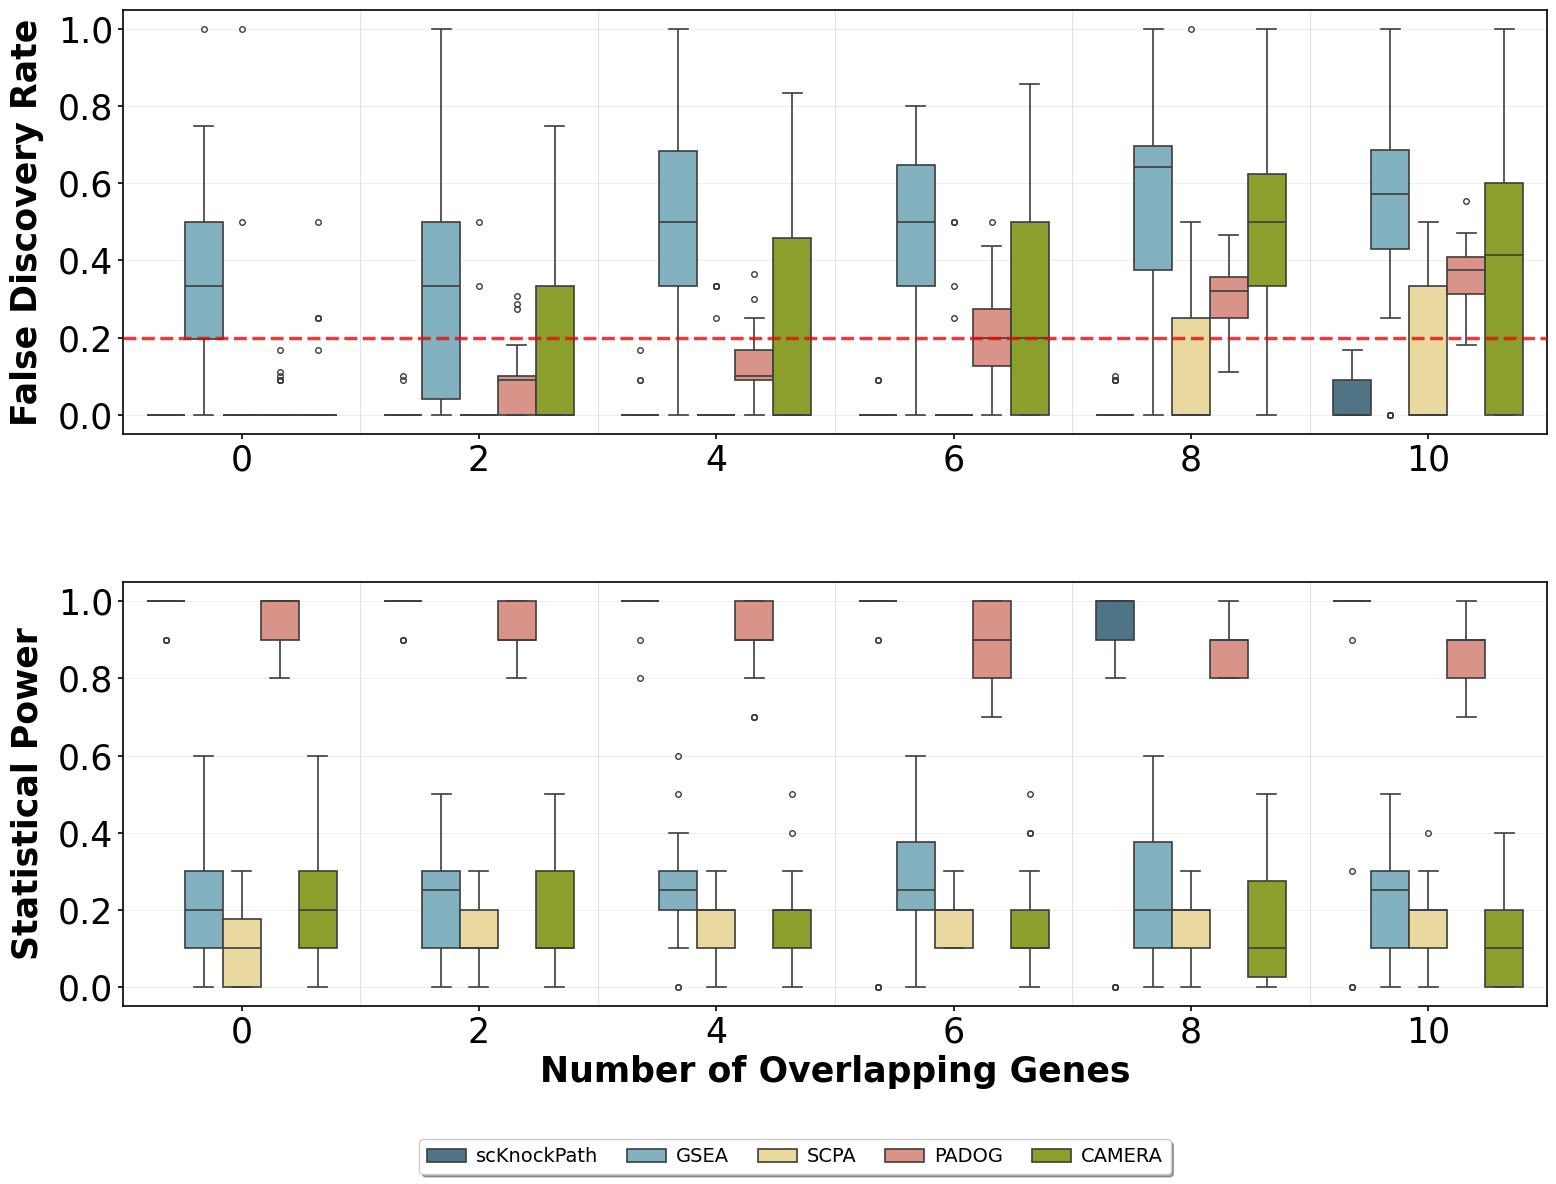

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ChromaPalette.chroma_palette import *
plt.rcParams['pdf.fonttype'] = 42

your_color_list = color_palette(name="Radiant",N=5)
combined_fdr_values_melted=load_res(res_type='fdr',param='overlap',params_range=range(0,11,2))
combined_powers_values_melted=load_res(res_type='power',param='overlap',params_range=range(0,11,2))

plot_fdr_power_boxplots(
    combined_fdr_values_melted,
    combined_powers_values_melted,
    colors,
    x_ticks=list(range(0,11,2)),
    param='n_overlap',
    x_fontsize=25,
    y_fontsize=25,
    x_label='Number of Overlapping Genes',
    save_path='./results/simulation_exp/combined_vertical_overlap_boxplot_fdr_power.pdf'
)


## sparsity

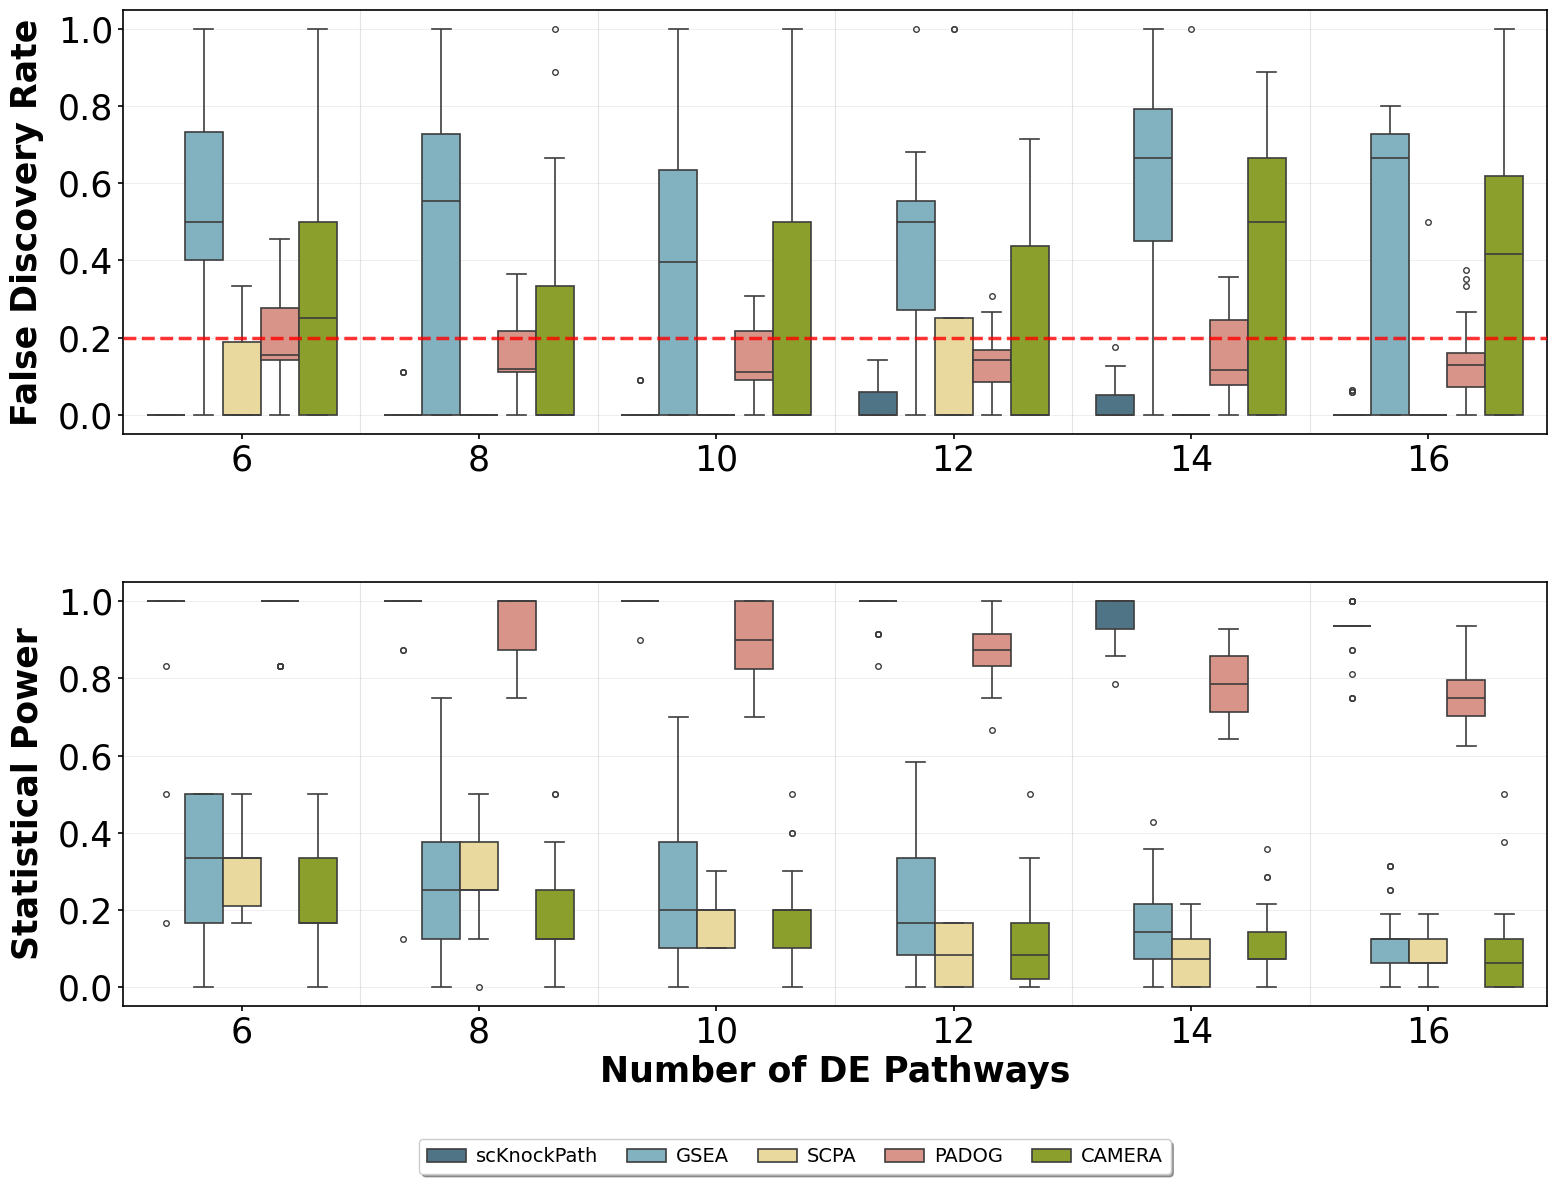

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ChromaPalette.chroma_palette import *
plt.rcParams['pdf.fonttype'] = 42
# your_color_list = color_palette(name="Radiant",N=5)


combined_fdr_values_melted=load_res(res_type='fdr',param='sparsity',params_range=range(6,17,2))
combined_power_values_melted=load_res(res_type='power',param='sparsity',params_range=range(6,17,2))

plot_fdr_power_boxplots(
    combined_fdr_values_melted,
    combined_power_values_melted,
    colors,
    x_ticks=list(range(6,17,2)),
    param='n_sparsity',
    x_fontsize=25,
    y_fontsize=25,
    x_label='Number of DE Pathways',
    save_path='./results/simulation_exp/combined_vertical_sparsity_boxplot_fdr_power.pdf'
)

## sample

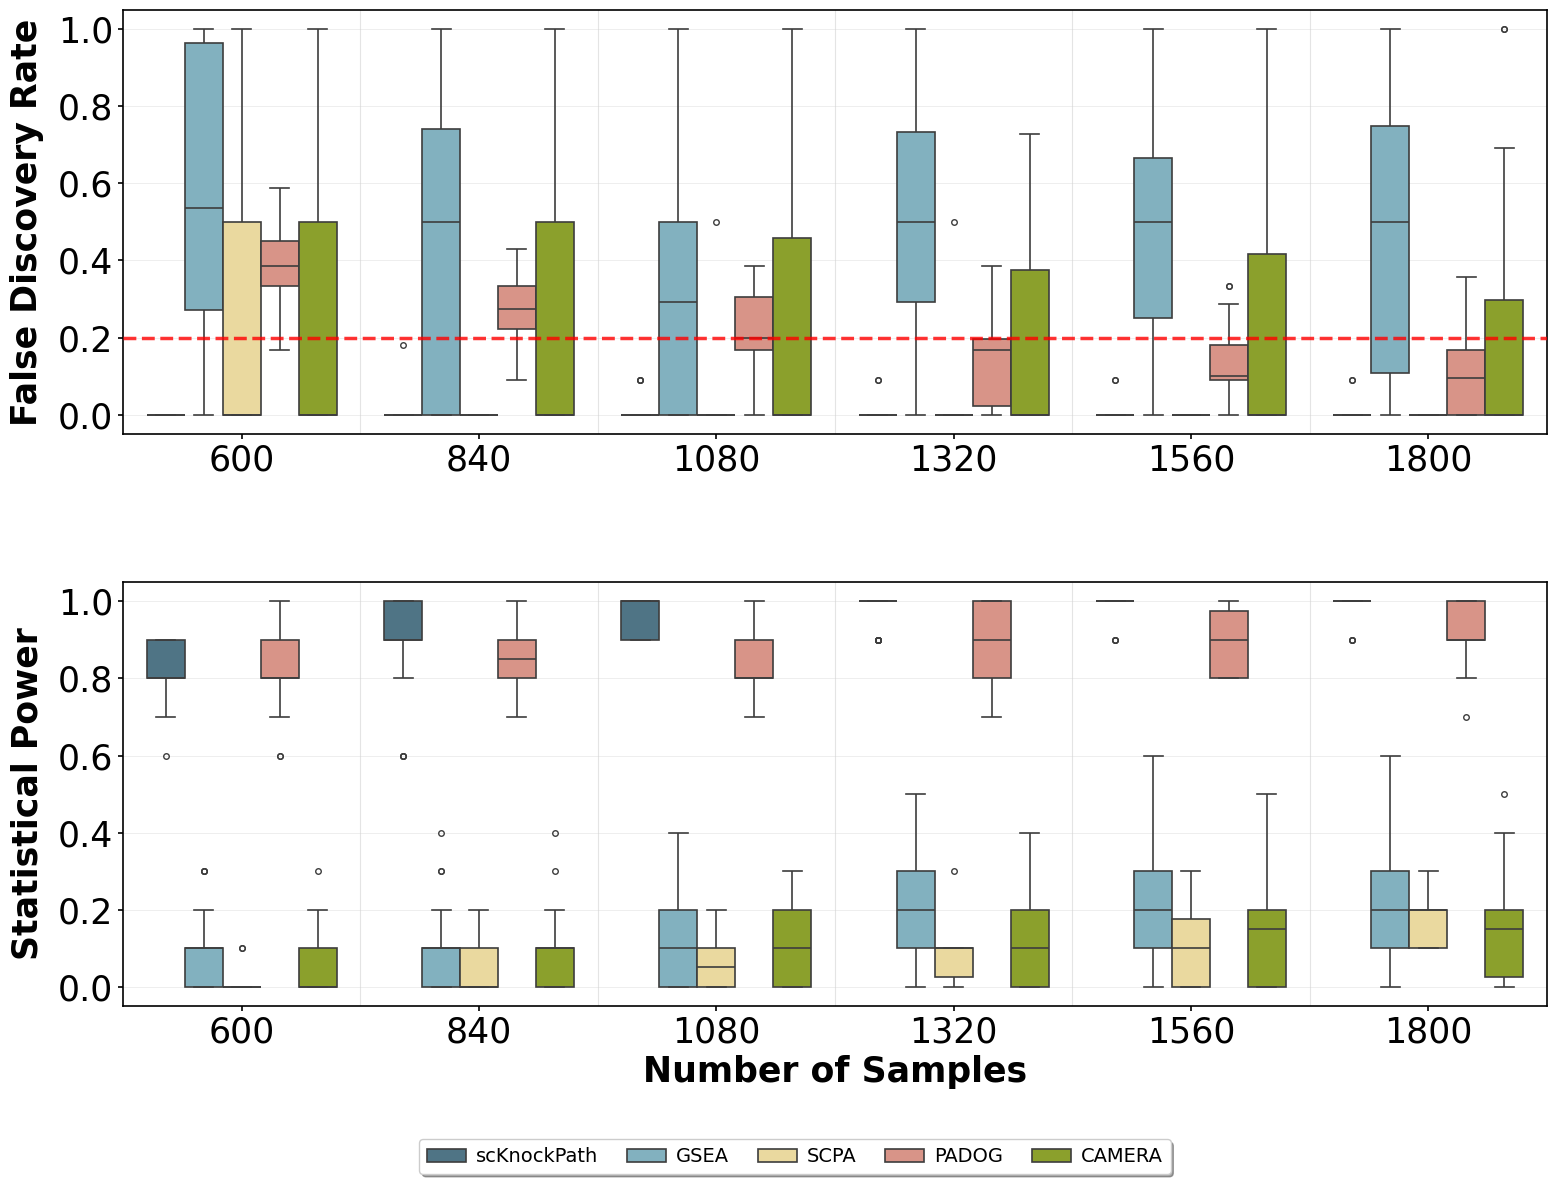

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
# your_color_list = color_palette(name="Radiant",N=5)


combined_fdr_values_melted=load_res('fdr','sample',np.linspace(600, 1800, 6).astype(int))
combined_powers_values_melted=load_res('power','sample',np.linspace(600, 1800, 6).astype(int))

plot_fdr_power_boxplots(
    combined_fdr_values_melted,
    combined_powers_values_melted,
    colors,
    x_ticks=list(np.linspace(600, 1800, 6).astype(int)),
    param='n_sample',
    x_fontsize=25,
    y_fontsize=25,
    x_label='Number of Samples',
    save_path='./results/simulation_exp/combined_vertical_sample_boxplot_fdr_power.pdf'
)

## Target FDRs

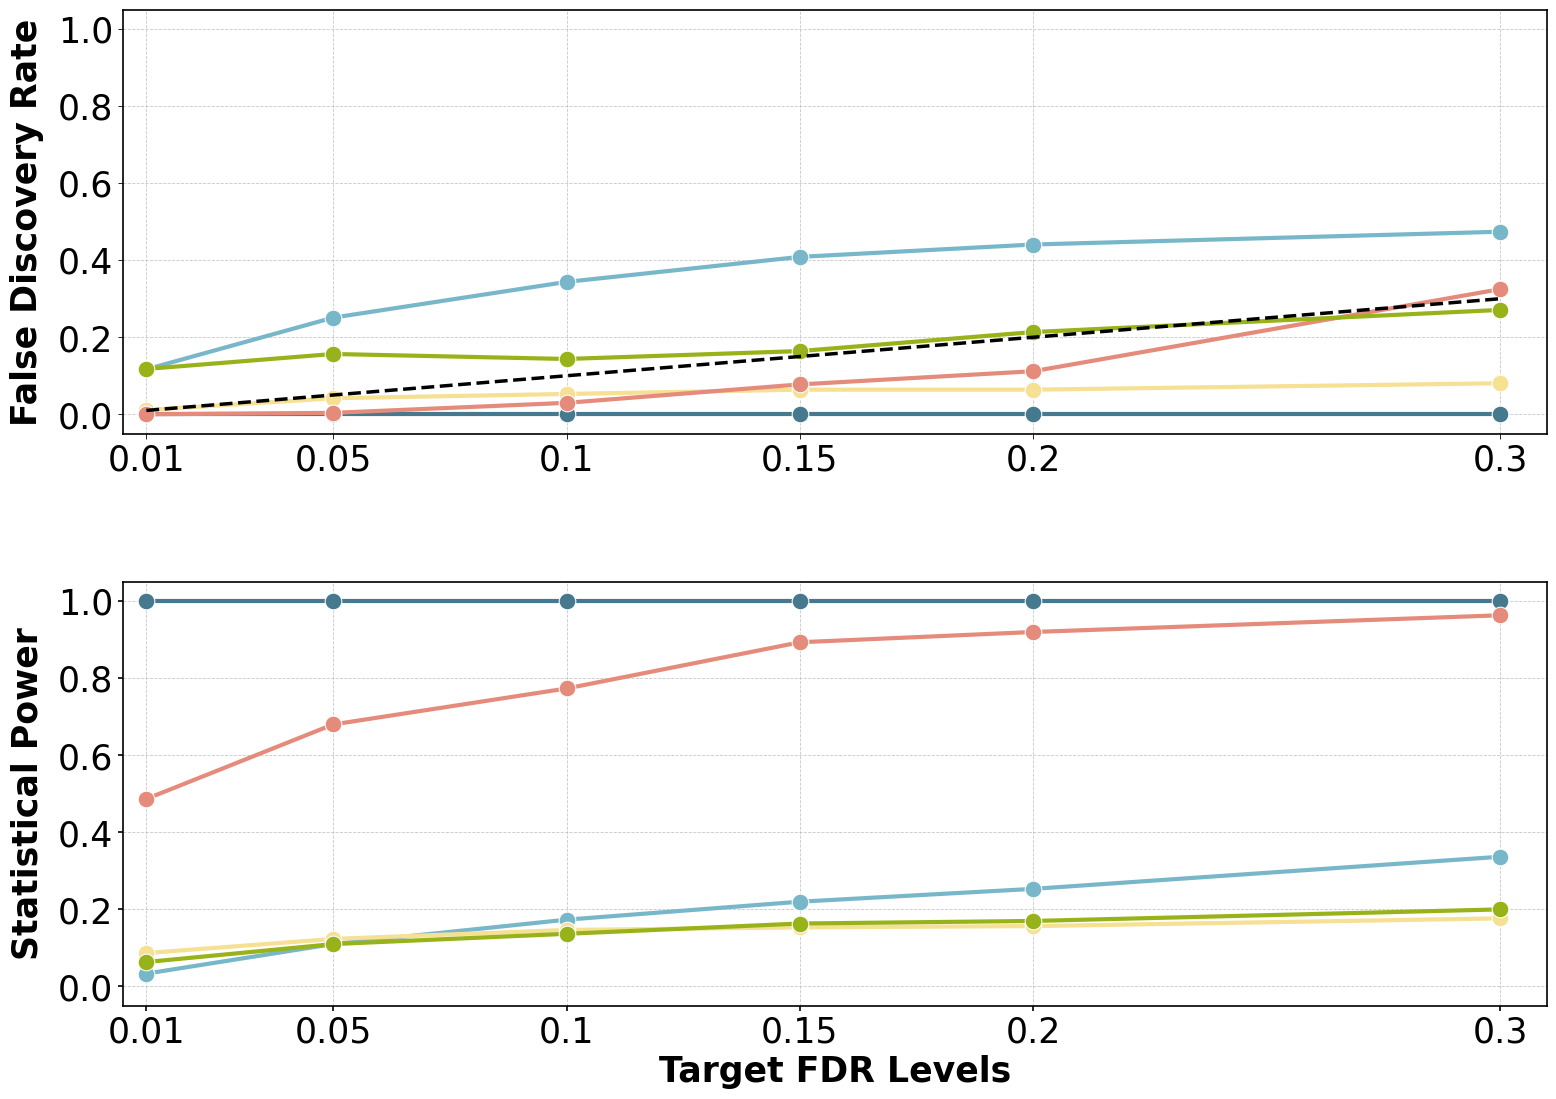

In [9]:

target_fdrs=[0.01,0.05,0.1,0.15,0.2,0.3]
combined_fdr_values_melted=load_res('fdr','fdrs',target_fdrs)
combined_powers_values_melted=load_res('power','fdrs',target_fdrs)


plot_fdr_power_line(
    combined_fdr_values_melted,
    combined_powers_values_melted,
    colors,
    x_ticks=target_fdrs,
    param='n_fdrs',
    x_fontsize=25,
    y_fontsize=25,
    x_label='Target FDR Levels',
    save_path='./results/simulation_exp/combined_vertical_targetfdrs_fdr_power.pdf'
)

## ablation-sgl

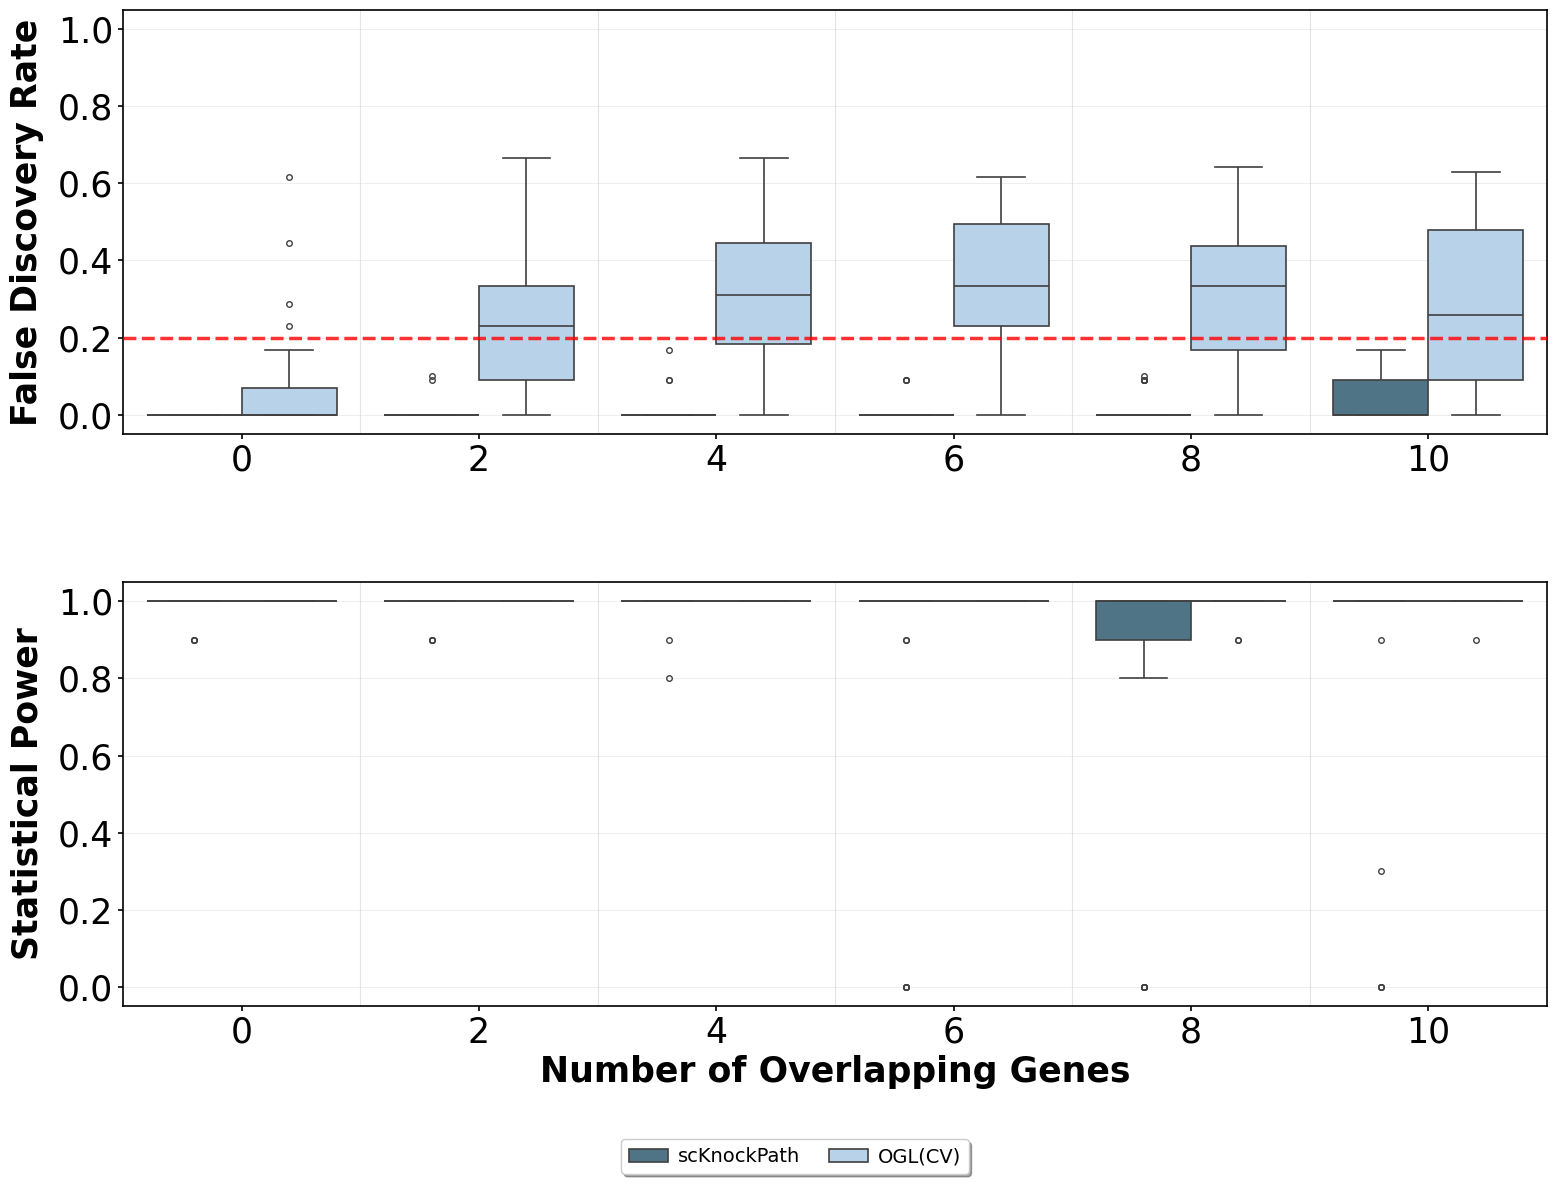

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
n_overlap=10
seed=46


def load_res_abl(res_type='fdr',param='overlap',params_range=range(0,11,2)):
    # get scKnockPath results
    path_folder='scKP_run3' if param=='sample' else \
        'scKP_run2' if param=='sparsity' else \
        'scKP_run'

    values_list = []
    for i in params_range:
        file_path = f'./results/simulation_exp/{path_folder}/results/n_{param}={i}_results.npz'  if param in ['overlap','sparsity'] else \
            f'./results/simulation_exp/{path_folder}/results/n_samples={i}_results.npz'
        data = np.load(file_path)
        values_list.append(data['fdrs'] if res_type=='fdr' else data['powers'])
    
    values_list_abl = []
    for i in params_range:
        file_path = f'./results/simulation_exp/ablation_{param}/n_{param}={i}/n_{param}={i}_results.npz' 
        data = np.load(file_path)
        values_list_abl.append(data['fdrs'] if res_type=='fdr' else data['powers'])
        
    values_scknockpath=pd.DataFrame(values_list).T
    values_list_abl=pd.DataFrame(values_list_abl).T
    
    values_scknockpath['Method'] = 'scKnockPath'
    values_list_abl['Method'] = 'OGL(CV)'
    combined_values = pd.concat([values_scknockpath, values_list_abl])
    combined_fdr_values_melted=combined_values.melt(id_vars=['Method'], var_name=f'n_{param}', value_name='FDR' if res_type=='fdr' else 'Power')
    
    return combined_fdr_values_melted
    
combined_fdr_values_melted = load_res_abl(res_type='fdr',param='overlap',params_range=range(0,11,2))
combined_powers_values_melted=load_res_abl(res_type='power',param='overlap',params_range=range(0,11,2))

colors=['#46788E',"#B0D2F2"]
plot_fdr_power_boxplots(
    combined_fdr_values_melted,
    combined_powers_values_melted,
    colors,
    x_ticks=list(range(0,11,2)),
    param='n_overlap',
    x_fontsize=25,
    y_fontsize=25,
    x_label='Number of Overlapping Genes',
    save_path='./results/simulation_exp/combined_vertical_abl_overlap_boxplot_fdr_power.pdf'
)


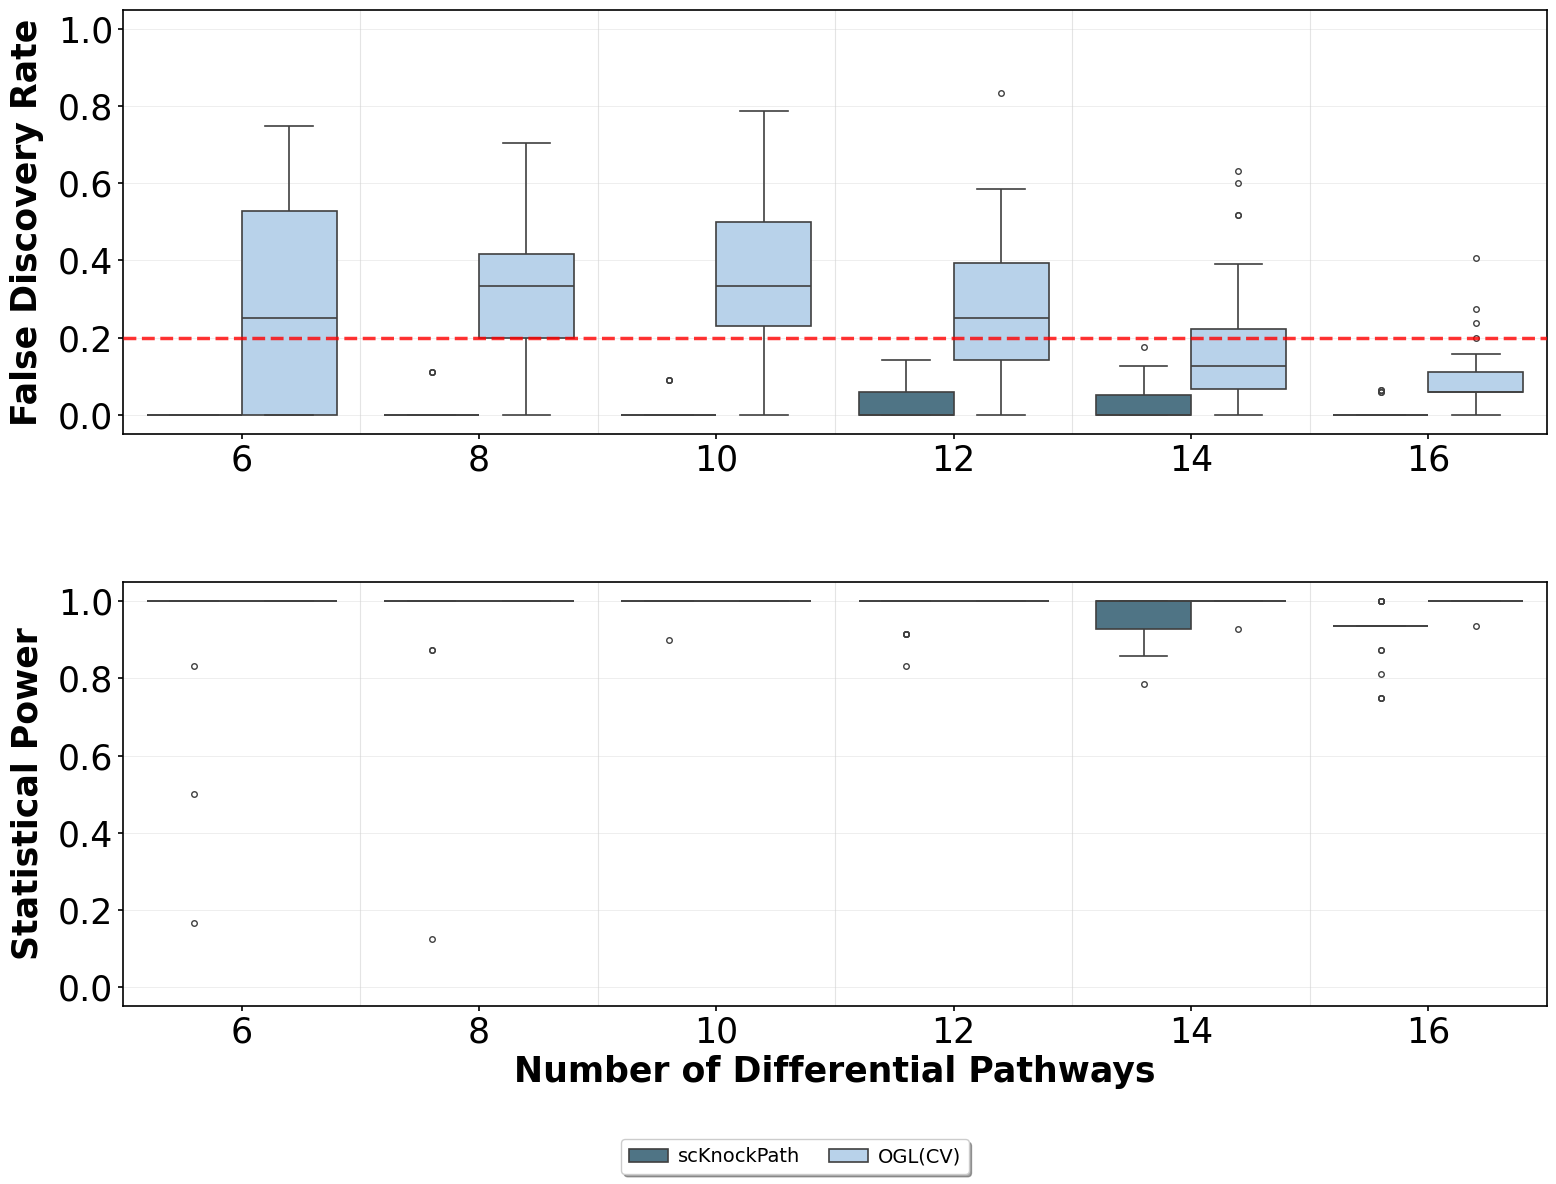

In [11]:
param='sparsity'
params_range=list(range(6,17,2))
combined_fdr_values_melted = load_res_abl(res_type='fdr',param=param,params_range=params_range)
combined_powers_values_melted=load_res_abl(res_type='power',param=param,params_range=params_range)

colors=['#46788E',"#B0D2F2"]
plot_fdr_power_boxplots(
    combined_fdr_values_melted,
    combined_powers_values_melted,
    colors,
    x_ticks=params_range,
    param=f'n_{param}',
    x_fontsize=25,
    y_fontsize=25,
    x_label='Number of Differential Pathways',
    save_path=f'./results/simulation_exp/combined_vertical_abl_{param}_boxplot_fdr_power.pdf'
)

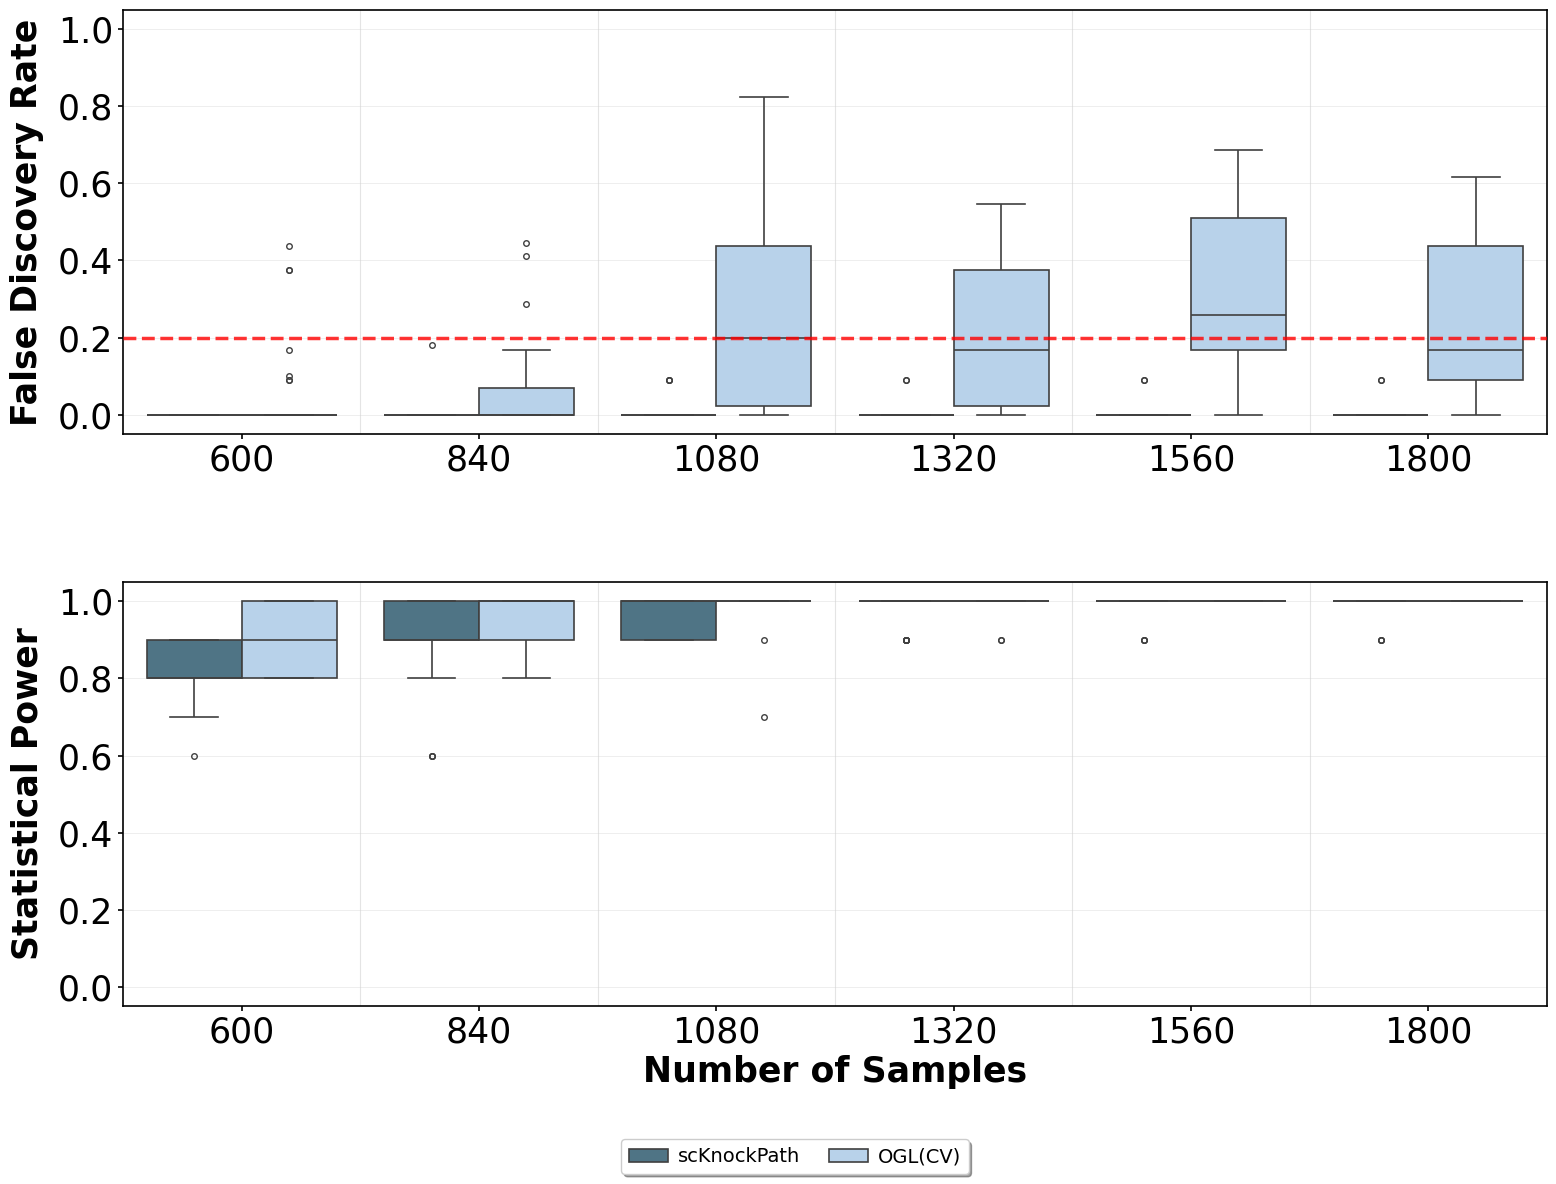

In [12]:
param='sample'
params_range=np.linspace(600, 1800, 6).astype(int)
combined_fdr_values_melted = load_res_abl(res_type='fdr',param=param,params_range=params_range)
combined_powers_values_melted=load_res_abl(res_type='power',param=param,params_range=params_range)

colors=['#46788E',"#B0D2F2"]
plot_fdr_power_boxplots(
    combined_fdr_values_melted,
    combined_powers_values_melted,
    colors,
    x_ticks=params_range,
    param=f'n_{param}',
    x_fontsize=25,
    y_fontsize=25,
    x_label='Number of Samples',
    save_path=f'./results/simulation_exp/combined_vertical_abl_{param}_boxplot_fdr_power.pdf'
)

# null Data

## Number of selected pathways

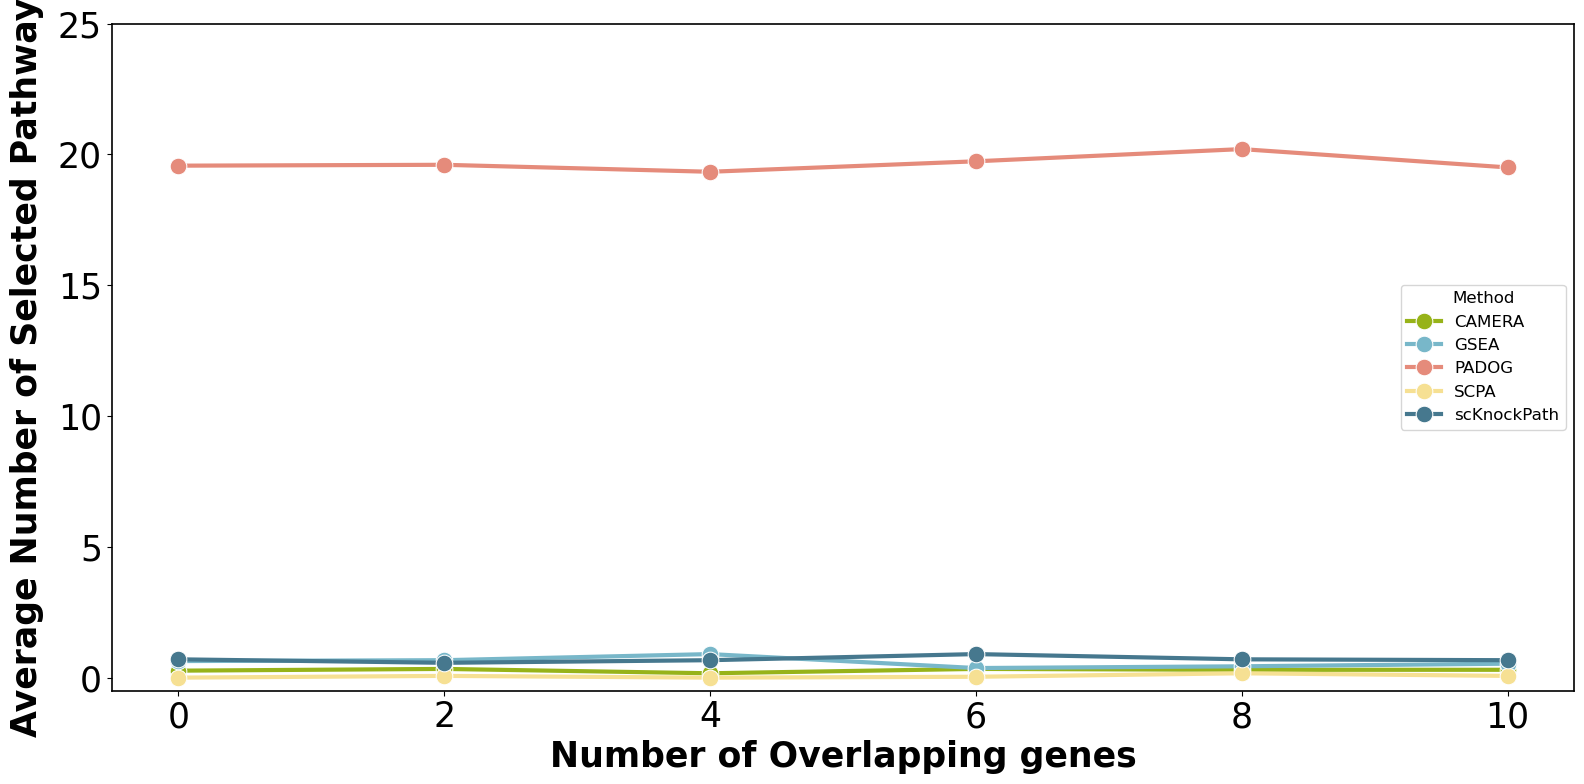

In [37]:
import pandas as pd
import numpy as np
def load_null_results(param='overlap',params_range=range(0,11,2)):
    values_padog=pd.read_csv(f'./results/simulation_exp/PADOG_null_{param}_results/PADOG_null_{param}_n_selected_values.csv')
    values_camera=pd.read_csv(f'./results/simulation_exp/CAMERA_null_{param}_results/CAMERA_null_{param}_n_selected_values.csv')
    values_scpa=pd.read_csv(f'./results/simulation_exp/SCPA_null_{param}_results/SCPA_null_{param}_n_selected_values.csv')
    values_gsea=pd.read_csv(f'./results/simulation_exp/GSEA_null_{param}_results/GSEA_null_{param}_n_selected_values.csv')
    
    values_camera.columns = values_gsea.columns
    values_padog.columns = values_gsea.columns
    values_scpa.columns = values_gsea.columns
    
    values_list = []
    for i in params_range:
        file_path = f'./results/simulation_exp/scKP_run_null_{param}/results/n_{param}={i}_results.npz'
        data = np.load(file_path)
        values_list.append(data['n_selected_pathways'] )
    
    values_scknockpath=pd.DataFrame(values_list,index=values_gsea.columns).T
    
    values_gsea['Method'] = 'GSEA'
    values_scknockpath['Method'] = 'scKnockPath'
    values_padog['Method'] = 'PADOG'
    values_camera['Method'] = 'CAMERA'
    values_scpa['Method'] = 'SCPA'

    combined_values=pd.concat([values_scknockpath,values_gsea,values_padog,values_camera,values_scpa],)

    combined_values_melted = combined_values.melt(id_vars=['Method'], var_name=f'n_{param}', value_name='n_selected')

    return combined_values_melted


combined_values_melted=load_null_results(param='overlap',params_range=range(0,11,2))



import matplotlib.pyplot as plt
import seaborn as sns

def plot_n_selected_line(data,param='overlap'):
    plot_data = data.copy()
    plot_data[f'n_{param}'] = pd.to_numeric(plot_data[f'n_{param}'], errors='coerce')
    plot_data = plot_data.dropna(subset=[f'n_{param}'])
    summary = (
        plot_data.groupby(['Method', f'n_{param}'], as_index=False)['n_selected']
        .mean()
        .sort_values(['Method', f'n_{param}'])
    )

    plt.figure(figsize=(16, 8))
    sns.lineplot(
        data=summary,
        x=f'n_{param}',
        y='n_selected',
        hue='Method',
        marker='o',
        palette=['#97B319','#78B7C9','#E58B7B','#F6E093','#46788E' ],
        linewidth=3,
        markersize=12,
    )
    label_fontsize=25
    if param=='overlap':
        plt.xlabel(f'Number of Overlapping genes',fontsize=label_fontsize,fontweight='bold')
    elif param=='sample':
        plt.xlabel(f'Number of Samples',fontsize=label_fontsize,fontweight='bold')
    plt.ylabel('Average Number of Selected Pathways',fontsize=label_fontsize, labelpad=10,fontweight='bold')
    
    tick_fontsize=25
    plt.xticks(sorted(summary[f'n_{param}'].unique()), fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.ylim(-0.5, 25)
    plt.tight_layout()

plt.rcParams['pdf.fonttype'] = 42
plot_n_selected_line(combined_values_melted,param='overlap')
plt.savefig('./results/simulation_exp/num_selected_pathways_overlap_lineplot.pdf', dpi=300,bbox_inches='tight')

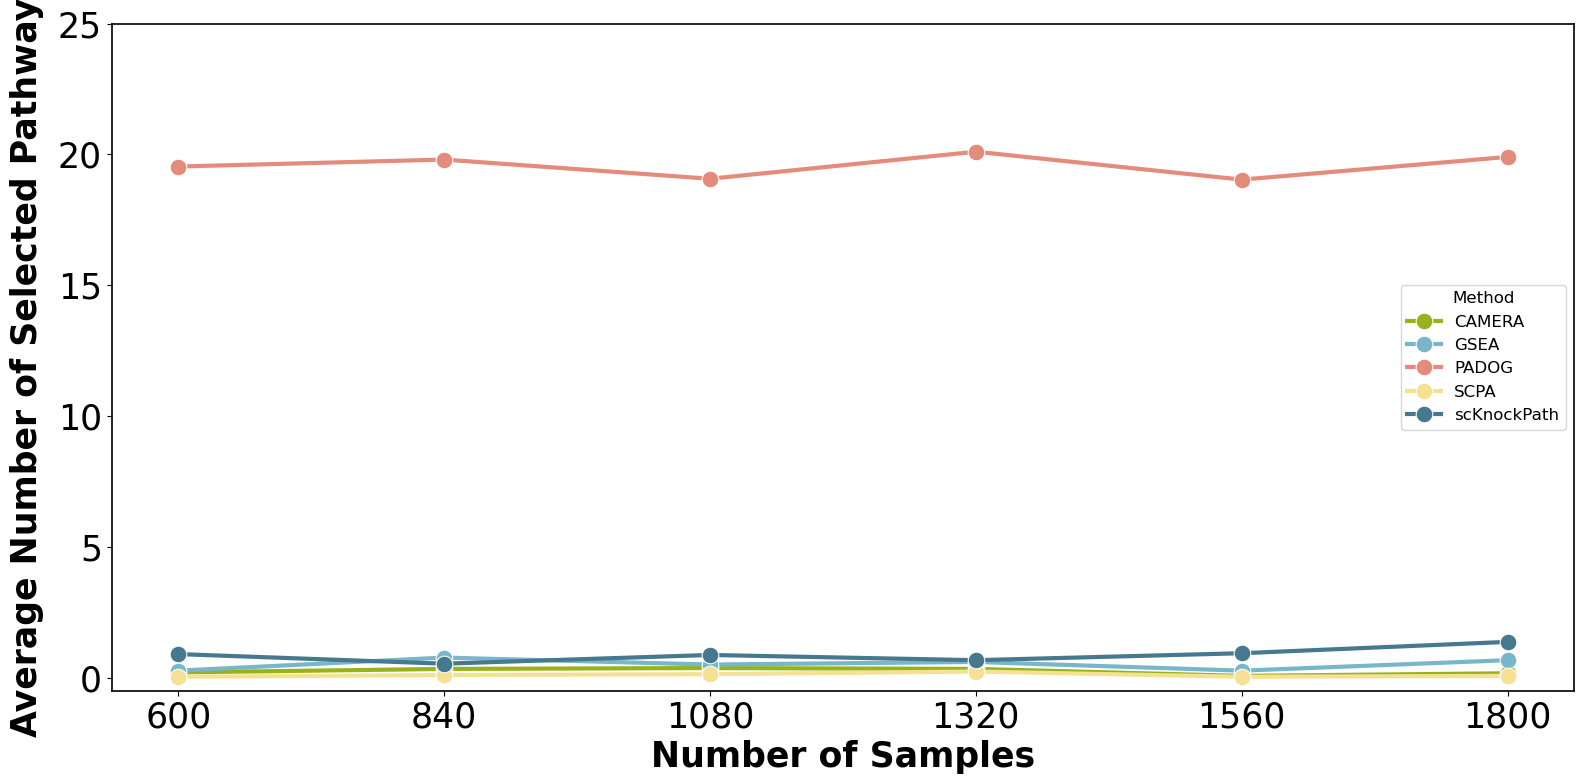

In [38]:
combined_values_melted=load_null_results(param='sample',params_range=range(600,1801,240))
plot_n_selected_line(combined_values_melted,param='sample')
plt.savefig('./results/simulation_exp/num_selected_pathways_sample_lineplot.pdf', dpi=300,bbox_inches='tight')

## overlap

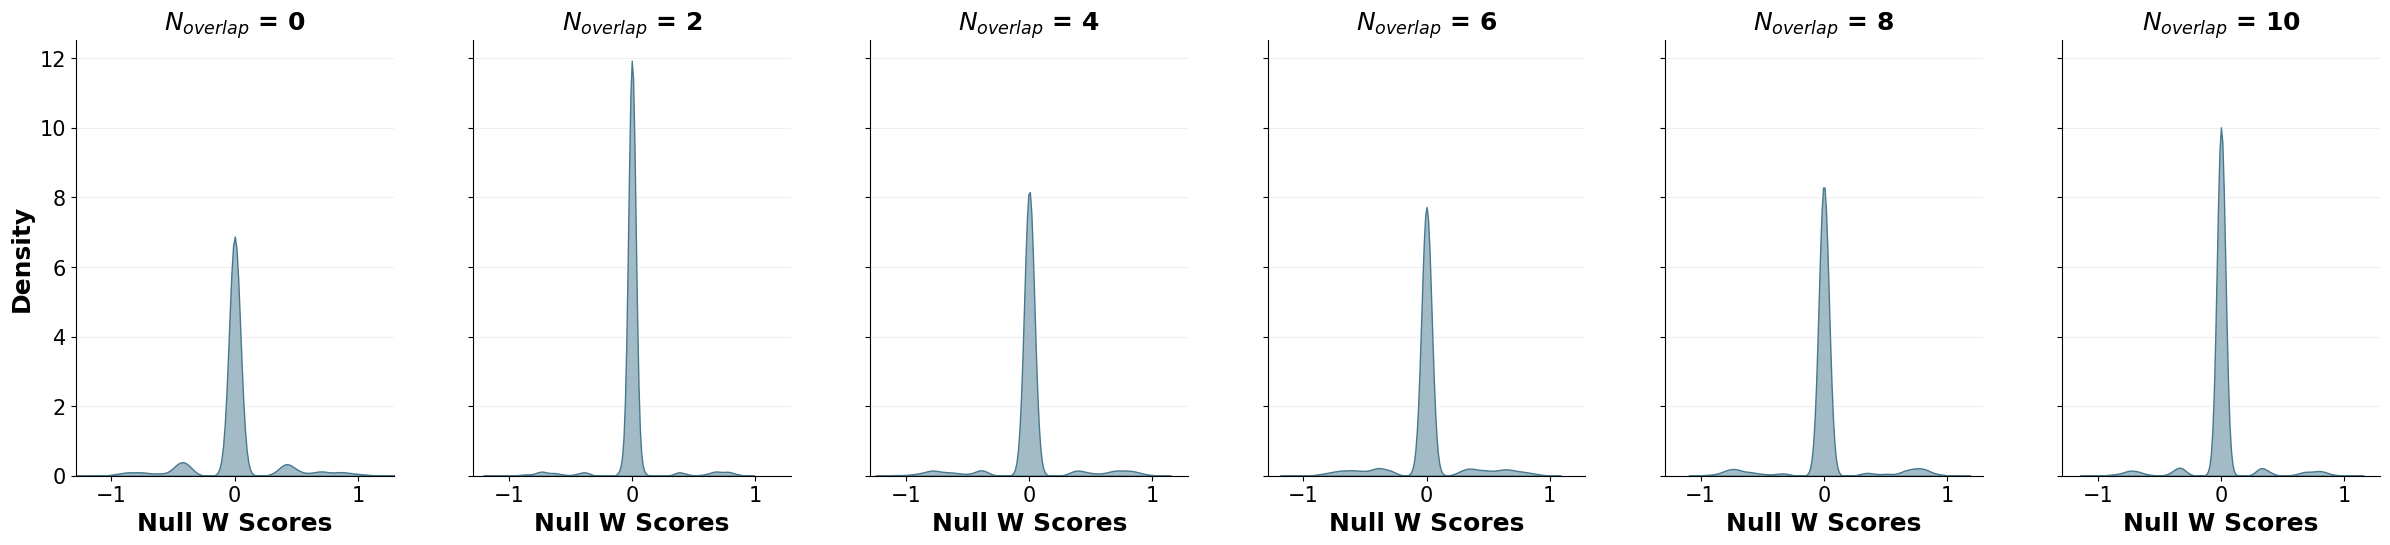

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import sys
import seaborn as sns
import scanpy as sc
sys.path.insert(0, './model')
import model_lambda
plt.rcParams['pdf.fonttype'] = 42

def load_Wg(param='overlap',param_range=range(0,11,2)):
    
    seeds = np.arange(46, 76)

    wg_per_param= {}

    for param_value in param_range:
        param_wg = []
        for seed in seeds:
            file_path = f'./results/simulation_exp/scKP_run_null_{param}/n_{param}={param_value}/100pathways_{param_value}{param}_null_seed={seed}_lambda.pkl'
            with open(file_path, 'rb') as fh:
                saved_model = pkl.load(fh)
            param_wg.append(saved_model.Wg)

        param_wg = np.concatenate(param_wg)

        wg_per_param[param_value] = param_wg
    return wg_per_param

def plot_kde(wg_per_param,param='overlap'):
    global_max = 0
    for param_value in wg_per_param:
        global_max = max(global_max, np.max(np.abs(wg_per_param[param_value])))

    param_range = sorted(wg_per_param.keys())
    hist_counts, hist_bins = np.histogram(wg_per_param[param_range[0]], bins=41)
    left = hist_counts[:hist_counts.size // 2]
    right = hist_counts[::-1][:hist_counts.size // 2]
    symmetry_score = np.mean(np.abs(left - right) / (left + right + 1e-8))
    skewness = np.mean(((wg_per_param[param_range[0]] - 0) / wg_per_param[param_range[0]].std(ddof=1)) ** 3) if wg_per_param[param_range[0]].std(ddof=1) > 0 else 0.0

    x_grid = np.linspace(-global_max, global_max, 512)
    fig, axes = plt.subplots(1, len(param_range), figsize=(24, 6), sharey=True)
    color = '#46788E'


    for ax, param_value in zip(axes, param_range):
        data = wg_per_param[param_value]
        if np.ptp(data) < 1e-12:
            plot_data = data + np.random.normal(scale=1e-4, size=data.size)
            sns.kdeplot(plot_data, ax=ax, color=color, bw_adjust=0.8, fill=True, alpha=0.5)
            ax.axvline(data[0], color=color, linestyle='--', linewidth=1.5, alpha=0.8)
        else:
            sns.kdeplot(data, ax=ax, color=color, bw_adjust=0.8, fill=True, alpha=0.5)
        ax.set_title(f'$N_{{{param}}}$ = {param_value}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Null W Scores', fontsize=18, weight='bold')
        ax.set_xlim(-global_max, global_max)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.grid(True, axis='y', alpha=0.2)
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
        if ax is axes[0]:
            ax.set_ylabel('Density', fontsize=18,weight='bold')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, wspace=0.25)
    plt.savefig(f'./results/simulation_exp/null_{param}_W_density.pdf', 
                dpi=300, 
                bbox_inches='tight', 
                facecolor='white', 
                edgecolor='none',
                pad_inches=0.1)
    plt.show()


wg_per_param=load_Wg(param='overlap',param_range=range(0,11,2))

wg_per_param
plot_kde(wg_per_param)

## sample

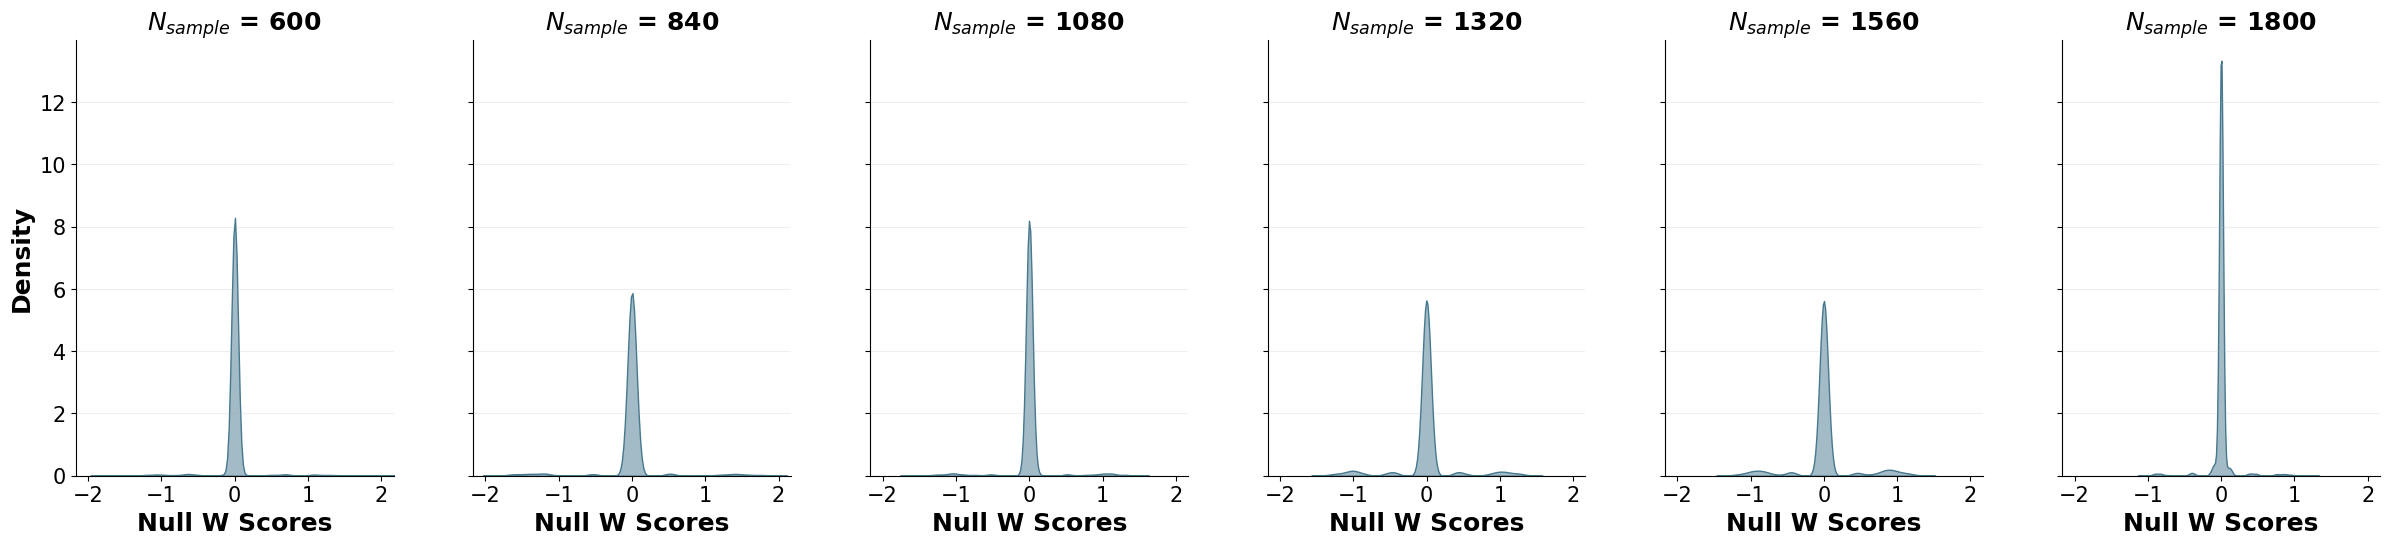

In [47]:
wg_per_param=load_Wg(param='sample',param_range=range(600,1801,240))

wg_per_param
plot_kde(wg_per_param,param='sample')